<a href="https://colab.research.google.com/github/MartinRomano-S/soa-tp2-tp3-grupo4/blob/master/HPC/Cuaderno_1_Mi%C3%A9rcoles__grupo4_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cuaderno 1 - Miércoles - Grupo 4: High Pass Filter

##Introducción

En este cuaderno se va a mostrar el funcionamiento de un filtro de imágenes High Pass. El objetivo de este filtro es detectar los bordes de una imágen donde el color homogéneo es obviado, pero las zonas de detalle se preservan para poder perfilar siluetas

El objetivo es comparar el tiempo de el funcionamiento del filtro con una ejecución en CPU contra una ejecución en GPU utilizando la biblioteca **pycuda** [1]

Para este filtro se aplica el concepto de *Image Convolution* [2] en el que por cada píxel se deben obtener una N cantidad de pixeles a su alrededor y multiplicarlos contra otra matriz de NxN para luego realizar una sumatoria de todos los valores resultantes y con este resultado actualizar el píxel inicial.

En este cuaderno se va a utilizar una matriz de N=3. La que mejor resultado nos dió para el filtro fue la siguiente:

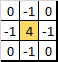

En la cual la celda coloreada representa al píxel actual al que se le está aplicando el filtro.

Por obvias razones, no se multiplicarán ni sumarán los píxeles que correspondan a una celda de la matriz NxN que contenga un cero.

##Armado del ambiente


Debido a que vamos a ejecutar código tanto en CPU como en GPU, necesitamos tener unas consideraciones previas.

1. Primero que nada hay que habilitar el entorno GPU.

  Para esto hay que ir a **Entorno de ejecución > Cambiar tipo de entorno de ejecución**. <br>Seleccionar GPU como *acelerador de hardware* y luego guardar.
2. Luego debemos instalar **pycuda** ya que vamos a trabajar con ésta biblioteca.
  <br>Para ello debemos ejecutar la siguiente instrucción:

In [2]:
!pip install pycuda

     |████████████████████████████████| 1.7MB 8.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626902 sha256=7658669292e93b2ca62d9435a7a50e42c835fe50cdd224398b0d34dc3a3d9bf2
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.7-py2.py3-none-any.whl size=60644 sha256=d2842774b63ba5b2d432065208d94001512613cba7ca20253aea7d4c5e80020b
  Stored in directory: /root/.cache/pip/wheels/a0/b5/e5/e65d25997fd77729b9aa214645add18688483e48bbcbab6ffc
Successfully built pytools


3. Debemos ingresar una imagen a la cual aplicarle el filtro y, además, definimos una función lambda para mostrar las métricas de tiempos.

In [4]:
url_imagen = "https://hotpot.ai/images/site/ai/remaster/teaser.jpg" #@param {type:"string"}

!wget {url_imagen} -O imagen.jpg

# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

--2021-06-26 18:50:53--  https://hotpot.ai/images/site/ai/remaster/teaser.jpg
Resolving hotpot.ai (hotpot.ai)... 172.67.72.40, 104.26.7.94, 104.26.6.94, ...
Connecting to hotpot.ai (hotpot.ai)|172.67.72.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 655258 (640K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 639.90K  --.-KB/s    in 0.03s   

2021-06-26 18:50:54 (21.0 MB/s) - ‘imagen.jpg’ saved [655258/655258]



##Desarrollo CPU

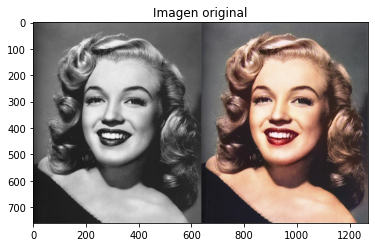

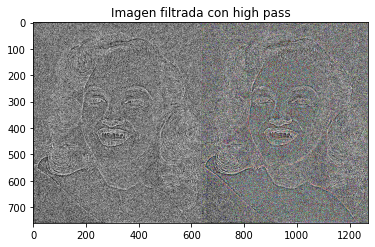

In [47]:
%matplotlib inline
from datetime import datetime

# Tiempo total de ejecución
tiempo_cpu_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image

# Gap que dejamos para aplicar el filtro
BORDER = 1

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre )
  
# Obtenemos las dimensiones de la imagen
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like( img_O_cpu)

# Tomo el tiempo en el que empieza la ejecución del filtro
tiempo_cpu_hp = datetime.now()

# Filtro a ejecutar en CPU
for y in range(BORDER, img_alto - BORDER):
  for x in range(BORDER, img_ancho - BORDER):
    sumR = 0
    sumG = 0
    sumB = 0
    pixel_R, pixel_G, pixel_B = img_O_cpu[y][x-1]
    sumR += pixel_R*-1
    sumG += pixel_G*-1
    sumB += pixel_B*-1
    pixel_R, pixel_G, pixel_B = img_O_cpu[y-1][x]
    sumR += pixel_R*-1
    sumG += pixel_G*-1
    sumB += pixel_B*-1
    pixel_R, pixel_G, pixel_B = img_O_cpu[y][x]
    sumR += pixel_R*4
    sumG += pixel_G*4
    sumB += pixel_B*4
    pixel_R, pixel_G, pixel_B = img_O_cpu[y+1][x]
    sumR += pixel_R*-1
    sumG += pixel_G*-1
    sumB += pixel_B*-1
    pixel_R, pixel_G, pixel_B = img_O_cpu[y][x+1]
    sumR += pixel_R*-1
    sumG += pixel_G*-1
    sumB += pixel_B*-1
    img_R_cpu[y][x] = [sumR, sumG, sumB]

# Obtengo la diferencia para saber cuanto tiempo transcurrió
tiempo_cpu_hp = datetime.now() - tiempo_cpu_hp

# Muestro la imagen Original el filtro.
plt.figure()
plt.title("Imagen original")
imgplot=plt.imshow(img_O_cpu)

plt.figure()
plt.title("Imagen filtrada con high pass")
imgplot=plt.imshow(img_R_cpu)

tiempo_cpu_total = datetime.now() - tiempo_cpu_total

##Desarrollo GPU

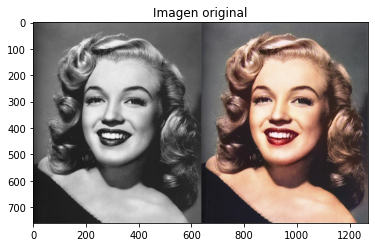

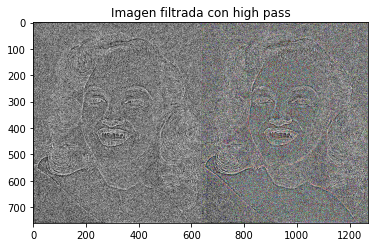

In [46]:
%matplotlib inline
from datetime import datetime

# Tiempo en CPU + GPU
tiempo_gpu_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

img_nombre = 'imagen.jpg'
image = Image.open(img_nombre) 

# summarize some details about the image
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like(img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  const int BORDER = 1;
  const int limxmin = BORDER;
  const int limxmax = ancho - BORDER;
  const int limymin = BORDER;
  const int limymax = alto - BORDER;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if(idx > limxmin && idx < limxmax && idy > limymin && idy < limymax )
  {
    int sumR = 0, sumG = 0, sumB = 0;

    //Pixel: X - 1 | Y
    sumR += img_O[(idx-1 +((idy)*ancho))*3    ]*-1;
    sumG += img_O[((idx-1+((idy)*ancho))*3)+1]*-1;
    sumB += img_O[((idx-1+((idy)*ancho))*3)+2]*-1;

    //Pixel: X | Y - 1
    sumR += img_O[(idx+((idy-1)*ancho))*3    ]*-1;
    sumG += img_O[((idx+((idy-1)*ancho))*3)+1]*-1;
    sumB += img_O[((idx+((idy-1)*ancho))*3)+2]*-1;

    //Pixel: X | Y
    sumR += img_O[(idx+((idy)*ancho))*3    ]*4;
    sumG += img_O[((idx+((idy)*ancho))*3)+1]*4;
    sumB += img_O[((idx+((idy)*ancho))*3)+2]*4;

    //Pixel: X | Y + 1
    sumR += img_O[(idx+((idy+1)*ancho))*3    ]*-1;
    sumG += img_O[((idx+((idy+1)*ancho))*3)+1]*-1;
    sumB += img_O[((idx+((idy+1)*ancho))*3)+2]*-1;

    //Pixel: X + 1 | Y
    sumR += img_O[(idx+1 +((idy)*ancho))*3    ]*-1;
    sumG += img_O[((idx+1+((idy)*ancho))*3)+1]*-1;
    sumB += img_O[((idx+1+((idy)*ancho))*3)+2]*-1;

    img_R[(idx+((idy)*ancho))*3    ] = sumR;
    img_R[((idx+((idy)*ancho))*3)+1] = sumG;
    img_R[((idx+((idy)*ancho))*3)+2] = sumB;
  }
}
""") 

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

# Definimos las dimensiones de hilos y bloques
dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

# Obtenemos el tiempo actual antes de la ejecución
tiempo_gpu_hp = datetime.now()

# Llamamos a la ejecución del filtro
kernel(numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1))

# Obtenemos la diferencia de tiempo para saber cuanto tiempo estuvo ejecutando
tiempo_gpu_hp = datetime.now() - tiempo_gpu_hp

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh(img_R_cpu, img_R_gpu)

# Muestro la imagen Original el filtro.
plt.figure()
plt.title("Imagen original")
imgplot=plt.imshow(img_O_cpu)

plt.figure()
plt.title("Imagen filtrada con high pass")
imgplot=plt.imshow(img_R_cpu)

tiempo_gpu_total = datetime.now() - tiempo_gpu_total

##Métricas

In [48]:
print (' _________________________________________________________')
print ("|{:<15}|{:<20}|{:<20}|".format('Tiempos','Implementación CPU','Implementación GPU'))
print ('|---------------|--------------------|--------------------|')
print ("|{:<15}|{:>20}|{:>20}|".format('Tiempo CPU', str(tiempo_en_ms(tiempo_cpu_hp)) + 'ms', str(tiempo_en_ms(tiempo_gpu_total - tiempo_gpu_hp)) + 'ms'))
print ("|{:<15}|{:>20}|{:>20}|".format('Tiempo GPU','0.0ms', str(tiempo_en_ms(tiempo_gpu_hp)) + 'ms'))
print ("|{:<15}|{:>20}|{:>20}|".format('Tiempo Total',  str(tiempo_en_ms(tiempo_cpu_total)) + 'ms', str(tiempo_en_ms(tiempo_gpu_total)) + 'ms'))
print ('|_______________|____________________|____________________|')

 _________________________________________________________
|Tiempos        |Implementación CPU  |Implementación GPU  |
|---------------|--------------------|--------------------|
|Tiempo CPU     |         40985.881ms|             81.81ms|
|Tiempo GPU     |               0.0ms|             0.425ms|
|Tiempo Total   |         41052.547ms|            82.235ms|
|_______________|____________________|____________________|


##Conclusiones

Como conclusiones, viendo las métricas obtenidas, vemos que el rendimiento al ejecutar el algoritmo del filtro con un entorno GPU y aprovechando la capacidad de los threads mejora considerablemente en comparación a la implementación CPU.

Hay que tener en cuenta que, para imágenes pequeñas, es posible que el algoritmo de CPU demore menos tiempo de ejecución. Esto se debe a que la implementación de GPU requiere un tiempo prácticamente fijo para la planificación de los threads que en imágenes grandes pasa desapercibido.

##Bibliografía

[1] PyCUDA Documentation: [doc](https://documen.tician.de/pycuda/)<br>
[2] GPU Computing: Image Convolution, Dipl.-Ing. Jan Novak, Dipl.-Inf. Gabor Liktor, Prof. Dr.-Ing. Carsten Dachsbacher: [PDF](https://cg.ivd.kit.edu/downloads/assignment3_GPUC.pdf)